# Peter og ulven: Introduksjon til forsterkende læring

I denne veiledningen skal vi lære hvordan vi kan bruke forsterkende læring på et problem med å finne veier. Settingen er inspirert av [Peter og ulven](https://en.wikipedia.org/wiki/Peter_and_the_Wolf), et musikalsk eventyr av den russiske komponisten [Sergei Prokofiev](https://en.wikipedia.org/wiki/Sergei_Prokofiev). Det er en historie om den unge pioneren Peter, som modig går ut av huset sitt til lysningen i skogen for å jage ulven. Vi skal trene maskinlæringsalgoritmer som vil hjelpe Peter med å utforske området rundt og lage et optimalt navigasjonskart.

Først, la oss importere en rekke nyttige biblioteker:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Oversikt over Forsterkende Læring

**Forsterkende Læring** (RL) er en læringsteknikk som lar oss lære en optimal oppførsel for en **agent** i et **miljø** ved å utføre mange eksperimenter. En agent i dette miljøet bør ha et **mål**, definert av en **belønningsfunksjon**.

## Miljøet

For enkelhets skyld, la oss anta at Peters verden er et kvadratisk brett med størrelse `width` x `height`. Hver celle på dette brettet kan enten være:
* **bakke**, som Peter og andre skapninger kan gå på
* **vann**, som man åpenbart ikke kan gå på
* **et tre** eller **gress** - et sted hvor man kan ta en pause
* **et eple**, som representerer noe Peter gjerne vil finne for å mate seg selv
* **en ulv**, som er farlig og bør unngås

For å arbeide med miljøet, vil vi definere en klasse kalt `Board`. For å unngå å gjøre denne notatboken for rotete, har vi flyttet all kode for å arbeide med brettet til en egen modul kalt `rlboard`, som vi nå skal importere. Du kan se inn i denne modulen for å få mer detaljer om implementasjonens indre mekanismer.


In [2]:
from rlboard import *

La oss nå lage et tilfeldig brett og se hvordan det ser ut:


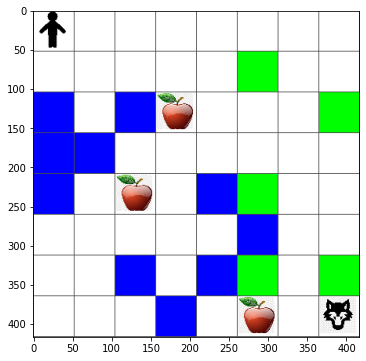

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## Handlinger og Regelverk

I vårt eksempel er Peters mål å finne et eple, samtidig som han unngår ulven og andre hindringer. For å oppnå dette kan han i hovedsak gå rundt til han finner et eple. Derfor kan han fra enhver posisjon velge mellom en av følgende handlinger: opp, ned, venstre og høyre. Vi vil definere disse handlingene som en ordbok og knytte dem til par av tilsvarende koordinatendringer. For eksempel vil det å bevege seg til høyre (`R`) tilsvare paret `(1,0)`.


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

Strategien til agenten vår (Peter) er definert av en såkalt **policy**. La oss se på den enkleste policyen, kalt **tilfeldig vandring**.

## Tilfeldig vandring

La oss først løse problemet vårt ved å implementere en strategi for tilfeldig vandring.


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

La oss kjøre eksperimentet med tilfeldig gange flere ganger og se gjennomsnittlig antall trinn tatt:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## Belønningsfunksjon

For å gjøre vår policy mer intelligent, må vi forstå hvilke trekk som er "bedre" enn andre.


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Q-Læring

Bygg en Q-Tabell, eller et flerdimensjonalt array. Siden brettet vårt har dimensjonene `width` x `height`, kan vi representere Q-Tabellen med et numpy-array med formen `width` x `height` x `len(actions)`:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Send Q-tabellen til plot-funksjonen for å visualisere tabellen på brettet:


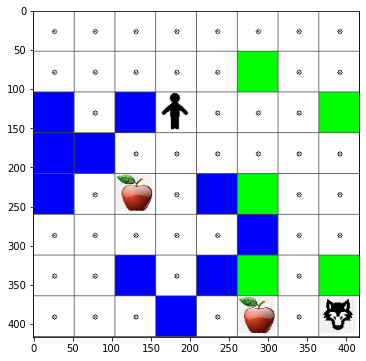

In [9]:
m.plot(Q)

## Essensen av Q-Learning: Bellman-ligningen og læringsalgoritmen

Skriv en pseudokode for vår læringsalgoritme:

* Initialiser Q-Tabellen Q med like verdier for alle tilstander og handlinger
* Sett læringsraten $\alpha\leftarrow 1$
* Gjenta simuleringen mange ganger
   1. Start på en tilfeldig posisjon
   1. Gjenta
        1. Velg en handling $a$ i tilstand $s$
        2. Utfør handlingen ved å gå til en ny tilstand $s'$
        3. Hvis vi møter en sluttspillbetingelse, eller totalbelønningen er for liten - avslutt simuleringen  
        4. Beregn belønning $r$ i den nye tilstanden
        5. Oppdater Q-Funksjonen i henhold til Bellman-ligningen: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. Oppdater totalbelønningen og reduser $\alpha$.

## Utnytte vs. Utforske

Den beste tilnærmingen er å balansere mellom utforskning og utnyttelse. Etter hvert som vi lærer mer om miljøet vårt, vil vi være mer tilbøyelige til å følge den optimale ruten, men samtidig velge den uutforskede veien av og til.

## Python-implementasjon

Nå er vi klare til å implementere læringsalgoritmen. Før det trenger vi også en funksjon som kan konvertere vilkårlige tall i Q-Tabellen til en vektor av sannsynligheter for tilsvarende handlinger:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Vi legger til en liten mengde `eps` til den opprinnelige vektoren for å unngå divisjon med 0 i starttilfellet, når alle komponentene i vektoren er identiske.

Den faktiske læringsalgoritmen vi skal kjøre i 5000 eksperimenter, også kalt **epoker**:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

Etter å ha utført denne algoritmen, bør Q-Tabellen oppdateres med verdier som definerer attraktiviteten til forskjellige handlinger på hvert trinn. Visualiser tabellen her:


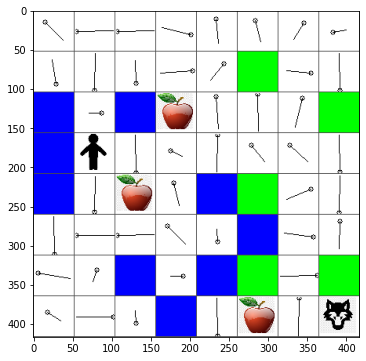

In [12]:
m.plot(Q)

## Sjekke policyen

Siden Q-Tabellen viser "attraktiviteten" til hver handling i hver tilstand, er det ganske enkelt å bruke den til å definere effektiv navigering i vår verden. I det enkleste tilfellet kan vi bare velge handlingen som tilsvarer den høyeste verdien i Q-Tabellen:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

Hvis du prøver koden ovenfor flere ganger, kan du legge merke til at den noen ganger bare "henger", og du må trykke på STOPP-knappen i notatboken for å avbryte den.

> **Oppgave 1:** Endre `walk`-funksjonen slik at den begrenser maksimal lengde på stien til et visst antall steg (for eksempel 100), og se hvordan koden ovenfor returnerer denne verdien fra tid til annen.

> **Oppgave 2:** Endre `walk`-funksjonen slik at den ikke går tilbake til steder den allerede har vært tidligere. Dette vil forhindre at `walk` går i løkker, men agenten kan fortsatt ende opp med å bli "fanget" på et sted den ikke kan komme seg ut fra.


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


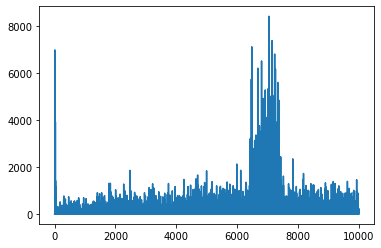

In [15]:
plt.plot(lpath)

Det vi ser her, er at gjennomsnittlig stilengde økte i starten. Dette skyldes sannsynligvis at når vi ikke vet noe om miljøet, er det lett å havne i dårlige tilstander, som vann eller ulv. Etter hvert som vi lærer mer og begynner å bruke denne kunnskapen, kan vi utforske miljøet lenger, men vi vet fortsatt ikke godt nok hvor eplene befinner seg.

Når vi har lært nok, blir det lettere for agenten å nå målet, og stilengden begynner å minke. Likevel er vi fortsatt åpne for utforskning, så vi avviker ofte fra den beste stien og prøver nye alternativer, noe som gjør stien lengre enn optimal.

Det vi også observerer i denne grafen, er at stilengden på et tidspunkt økte brått. Dette indikerer den stokastiske naturen til prosessen, og at vi på et tidspunkt kan "ødelegge" Q-Tabell-koeffisientene ved å overskrive dem med nye verdier. Dette bør ideelt sett minimeres ved å redusere læringsraten (dvs. mot slutten av treningen justerer vi Q-Tabell-verdiene kun med små endringer).

Alt i alt er det viktig å huske at suksessen og kvaliteten på læringsprosessen avhenger betydelig av parametere som læringsrate, læringsratereduksjon og diskonteringsfaktor. Disse kalles ofte **hyperparametere**, for å skille dem fra **parametere** som vi optimaliserer under treningen (f.eks. Q-Tabell-koeffisienter). Prosessen med å finne de beste verdiene for hyperparametere kalles **hyperparameteroptimalisering**, og det fortjener et eget tema.


## Øvelse
#### En Mer Realistisk Verden for Peter og Ulven

I vår situasjon kunne Peter bevege seg rundt nesten uten å bli sliten eller sulten. I en mer realistisk verden må han sette seg ned og hvile fra tid til annen, og også spise for å holde seg i live. La oss gjøre verden vår mer realistisk ved å implementere følgende regler:

1. Ved å bevege seg fra ett sted til et annet mister Peter **energi** og får noe **utmattelse**.
2. Peter kan få mer energi ved å spise epler.
3. Peter kan kvitte seg med utmattelse ved å hvile under treet eller på gresset (dvs. gå inn på et felt med et tre eller gress - grønt felt).
4. Peter må finne og drepe ulven.
5. For å drepe ulven må Peter ha visse nivåer av energi og utmattelse, ellers taper han kampen.

Endre belønningsfunksjonen ovenfor i henhold til spillereglene, kjør forsterkningslæringsalgoritmen for å lære den beste strategien for å vinne spillet, og sammenlign resultatene av tilfeldig vandring med algoritmen din når det gjelder antall spill vunnet og tapt.

> **Merk**: Du må kanskje justere hyperparametere for å få det til å fungere, spesielt antall epoker. Fordi suksess i spillet (å kjempe mot ulven) er en sjelden hendelse, kan du forvente mye lengre treningstid.



---

**Ansvarsfraskrivelse**:  
Dette dokumentet er oversatt ved hjelp av AI-oversettelsestjenesten [Co-op Translator](https://github.com/Azure/co-op-translator). Selv om vi tilstreber nøyaktighet, vennligst vær oppmerksom på at automatiske oversettelser kan inneholde feil eller unøyaktigheter. Det originale dokumentet på sitt opprinnelige språk bør anses som den autoritative kilden. For kritisk informasjon anbefales profesjonell menneskelig oversettelse. Vi er ikke ansvarlige for eventuelle misforståelser eller feiltolkninger som oppstår ved bruk av denne oversettelsen.
